# Demand Prediction For Cab Service - BloomReach

### Understand the Raw Dataset

In [232]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

In [233]:
data_raw = pd.read_excel('DemandPredictionDatasetBR.csv.xlsx',sheet_name = None)
data_raw.head()

,TripId,StartLat,StartLng,EndLat,EndLng,StartDateTime,EndDateTime,Status,CreatedTime
0,359822,18.5867,73.8154,18.5369,73.8713,2014-01-05 18:30:00,2014-01-05 19:30:00,cancelled,2013-12-02 18:33:51
1,365352,18.5809,73.7606,18.5981,73.7187,2014-01-01 10:00:00,2014-01-01 11:00:00,cancelled,2013-12-18 17:56:19
2,365353,18.5826,73.7684,18.5981,73.7187,2014-01-02 10:00:00,2014-01-02 11:00:00,cancelled,2013-12-18 17:56:19
3,365354,18.5826,73.7684,18.5981,73.7187,2014-01-03 10:00:00,2014-01-03 11:00:00,cancelled,2013-12-18 17:56:19
4,365355,18.5826,73.7684,18.5981,73.7187,2014-01-06 10:00:00,2014-01-06 11:00:00,cancelled,2013-12-18 17:58:46


In [234]:
len(data_raw)

181770

### Data cleaning
<br>Remove noise data and extra whitespace<br/>

In [235]:
df = data_raw[data_raw.StartLat != 0]
df = df[df.EndLat != 0]
df = df[df.StartLat.str.isdigit() != False]
df = df[df.EndLat.str.isdigit() != False]
df = df[df.StartLat < 40]
df = df[df.EndLat < 40]

In [236]:
len(df)

181191

## Perform exploratory analysis

<br>First, I will look at the distribution of the geolocation based on the coordinates. This could help partition of the location for further training.<br/>

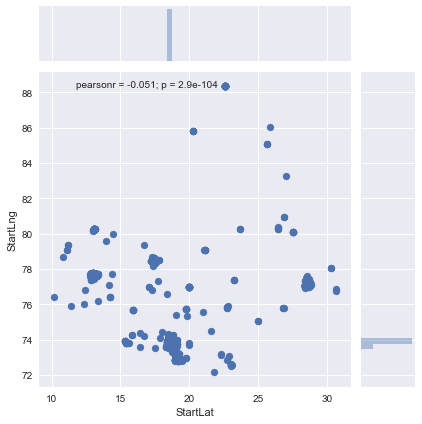

In [237]:
sns.jointplot(x="StartLat", y="StartLng", data=df);

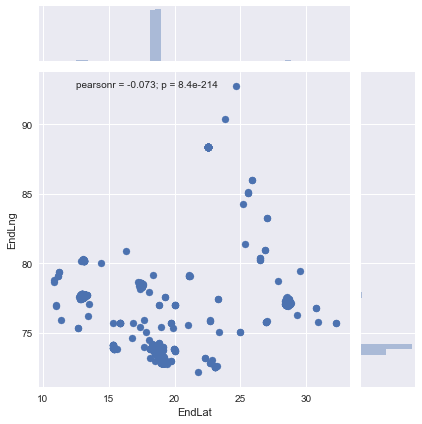

In [238]:
sns.jointplot(x="EndLat", y="EndLng", data=df);

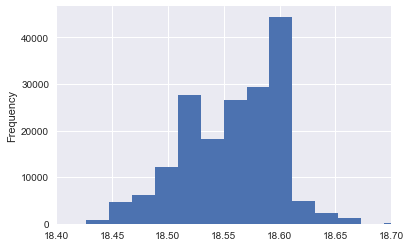

In [239]:
df['StartLat'].plot.hist(xlim=(18.4,18.7),bins=1000) 

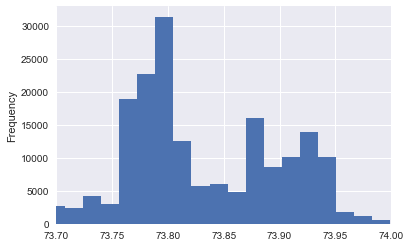

In [240]:
df['StartLng'].plot.hist(xlim=(73.7,74),bins=1000) 

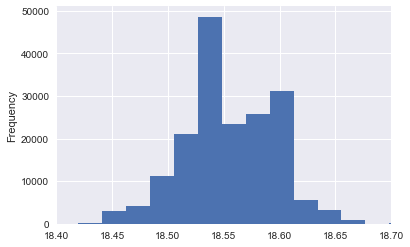

In [241]:
df['EndLat'].plot.hist(xlim=(18.4,18.7),bins=1000) 

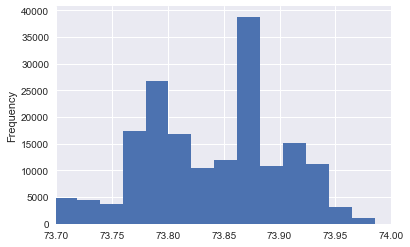

In [242]:
df['EndLng'].plot.hist(xlim=(73.7,74),bins=1000) 

<br>Second, I also plotted the distribution of the start time of trips. This could help to see how the time factors may affects the final results.<br/>

In [243]:
df_train = df
df_train['StartDateTime'] = pd.to_datetime(df_train['StartDateTime'])
df_train['EndDateTime'] = pd.to_datetime(df_train['EndDateTime'])
df_train['CreatedTime'] = pd.to_datetime(df_train['CreatedTime'])

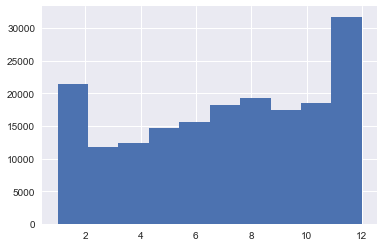

In [244]:
df_train['StartDateTime'].dt.month.hist()

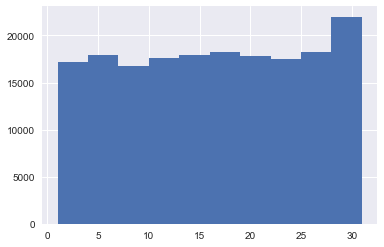

In [245]:
df_train['StartDateTime'].dt.day.hist()

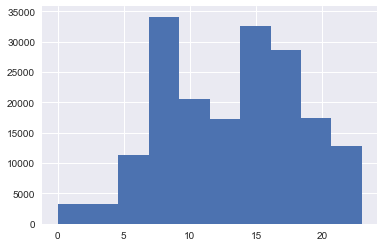

In [246]:
df_train['StartDateTime'].dt.hour.hist()

## Define a suitable demand prediction problem
<br>For this dataset, I will define demand prediction problem as, predicting the trip will be served by Anonymous, based on the geolocations and timestamps information. So that based on this predictive model, Anonymous can better estimate the anticipated demand and organize their drivers to sever those trips more likely severed by Anonymous.<br/>

## Perform feature engineering
<br>To select suitable features, the features have to be extracted from geolocation coordinates and timestamps informations first. After that, I also created some other reasonable features from existed features that may help improve the model performances.<br/>

### For geolocation coordinats
<br>From the exploratory analysis, I observed that trips are highly concentrate in a small region, so what I have to do is partition this region into several small regions for further analysis. After I inspected the distribution of the coordinates, I partitioned Latitude and Longtitude into 3 parts relatively, and assigned them a categorical value. <br/>

### For timestamps
<br>I extracted the Month, Day, Hour information of the start time of the trips. (Year is not necessary, cause all trips are in the same year)<br/>

### New features
<br>"Weekend": whether the start day is weekend or not<br/>
<br>"Duration": the duration of the trip, and this feature can include the trip-end information into feature map instead of more features<br/>
<br>"Reservation": the duration from the reservation is created to the start of the trip<br/>
<br>"Distance": the euclidean distance between the locations of the start and the end<br/>

In [248]:
df_train['Distance'] = np.sqrt((df_train['EndLat'] - df_train['StartLat']).astype(float)**2 + (df_train['EndLng'] - df_train['StartLng']).astype(float)**2)

df_train['Month'] = df_train['StartDateTime'].dt.month
df_train['Day'] = df_train['StartDateTime'].dt.day
df_train['Hour'] = df['StartDateTime'].dt.hour + round(df['StartDateTime'].dt.minute / 15) / 4
df_train['Weekend'] = df_train['StartDateTime'].dt.weekday >= 5
df_train['Duration'] = (df_train['EndDateTime']-df_train['StartDateTime']).astype('timedelta64[m]')
df_train['Reservation'] = (df_train['StartDateTime']-df_train['CreatedTime']).astype('timedelta64[h]')

df_train['Outcome'] = df_train['Status'] == 'completed'

df_train = df_train.drop('Status',axis=1)
df_train = df_train.drop('StartDateTime',axis=1)
df_train = df_train.drop('EndDateTime',axis=1)
df_train = df_train.drop('CreatedTime',axis=1)

In [249]:
for col in df_train['StartLat']:
    if col < 18.5:
        df_train['StartLat'] = 1
    elif 18.5 <= col < 18.6:
        df_train['StartLat'] = 2
    else:
        df_train['StartLat'] = 3

In [250]:
for col in df_train['EndLat']:
    if col < 18.5:
        df_train['EndLat'] = 1
    elif 18.5 <= col < 18.6:
        df_train['EndLat'] = 2
    else:
        df_train['EndLat'] = 3

In [251]:
for col in df_train['StartLng']:
    if col < 73.8:
        df_train['StartLng'] = 4
    elif 73.8 <= col < 73.9:
        df_train['StartLng'] = 5
    else:
        df_train['StartLng'] = 6

In [252]:
for col in df_train['EndLng']:
    if col < 73.8:
        df_train['EndLng'] = 4
    elif 73.8 <= col < 73.9:
        df_train['EndLng'] = 5
    else:
        df_train['EndLng'] = 6

In [268]:
df_train.head()

,TripId,StartLat,StartLng,EndLat,EndLng,Distance,Month,Day,Hour,Weekend,Duration,Reservation,Outcome
0,359822,2,4,1,6,0.074870,1,5,18.5,True,60.0,815.0,False
1,365352,2,4,1,6,0.045243,1,1,10.0,False,60.0,328.0,False
2,365353,2,4,1,6,0.052019,1,2,10.0,False,60.0,352.0,False
3,365354,2,4,1,6,0.052019,1,3,10.0,False,60.0,376.0,False
4,365355,2,4,1,6,0.052019,1,6,10.0,False,60.0,448.0,False


### Correlation of features ( checking high linearity relation among features)

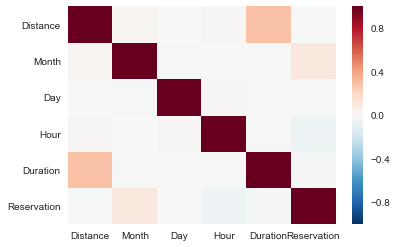

In [279]:
corr = df_train[['Distance','Month','Day','Hour','Duration','Reservation']].corr()
sns.heatmap(corr)

### Some trends of features
<br>As the new feature 'Reservation', we could noticed that, the trip created within 1 hour tend to be canceled at the end, while the trip created 2-8 hours before may more likely to be finished by Anonymous.<br/>

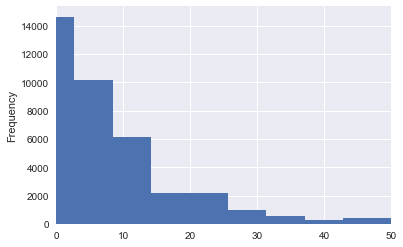

In [261]:
df_train[df_train.Outcome == False]['Reservation'].plot.hist(xlim=(0,50),bins=200)

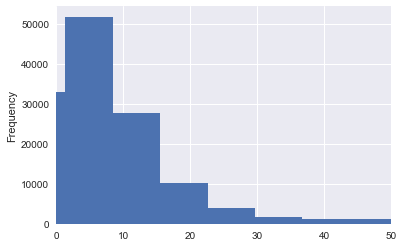

In [262]:
df_train[df_train.Outcome == True]['Reservation'].plot.hist(xlim=(0,50),bins=200)

## Describe the model

### Random Forest
<br>Random Forest has many advantages in a classification probelm. Comparing to other classification model, Random forests are extremely flexible and have very high accuracy. And it works well in a high dimension feature map with categorical variables (in this problem, we have categorical and non-categorical variables in feature map). Also, it is not sensitive to linearity of features and outliers (there are some outliers in geolocation in this problem). So Random Forest would be a good choice for this classification problem<br/>

<br>The RF model I used is from sklearn.<br/>

In [282]:
X = df_train.reset_index(drop=True)
y = np.where(X['Outcome'] == True, 1,0)
X = X.drop(['TripId','Outcome'],axis=1)
X = X.as_matrix().astype(np.float)

In [283]:
from sklearn.cross_validation import KFold

def run_cv(X,y,clf_class,**kwargs):
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    clf = clf_class(**kwargs)
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

### Result
<br>I used 5-fold cross-validation method to get the average accuracy of the random forest model.In k-fold cross-validation, the original sample is randomly partitioned into k equal sized subsamples. The advantage of this method over repeated random sub-sampling is that all observations are used for both training and validation, and each observation is used for validation exactly once. And from this method, it gave me accuracy around 75.7%.<br/> 
<br>Since it is a binary classifier, I also calculated the confusion matrix and the F1 score for further evaluation. The F1 score is a measure of a test's accuracy. It considers both the precision and the recall of the test to compute the score. From this test, F1 score is around 0.38, which is not as ideal as accuracy.<br/>

In [284]:
from sklearn.ensemble import RandomForestClassifier

def accuracy(y_true,y_pred):
    return np.mean(y_true == y_pred)

RF_CV_result = run_cv(X,y,RandomForestClassifier)

In [285]:
print("Random forest: " + str(accuracy(y, RF_CV_result)))

Random forest: 0.757151293387


In [289]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def cal_evaluation(classifier, cm):
    tp = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tn = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print(classifier)
    print("Accuracy is " + str(accuracy))
    print("Precision is " + str(precision))
    print("Recall is " + str(recall))
    print("F1 Score is "+ str(2*(precision*recall)/(precision+recall)))

def draw_confusion_matrices(confusion_matricies,class_names):
    class_names = class_names.tolist()
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    
y = np.array(y)
class_names = np.unique(y)

confusion_matrices = [
    ("Random Forest", confusion_matrix(y,RF_CV_result))]

Random Forest
Accuracy is 0.757151293387
Precision is 0.32541016596
Recall is 0.469866338495
F1 Score is 0.38451854753


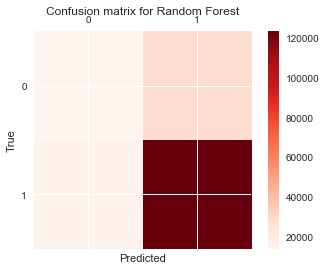

In [290]:
draw_confusion_matrices(confusion_matrices,class_names)

### XGBoost
<br>Another predictive model I tried is XGBoost. XGBoost(Extreme Gradient Boosting) is one of the most loved machine learning algorithms at Kaggle. It is built on the principles of gradient boosting framework, and it can easily handle both qualitative and categorical features, so it could a great fit for this problem. And XGBoost usually gives higher accuracy among most classifiers (that's why it is used most in competition).<br/>
<br>To implement XGBoost, I used one-hot encoder to encode categorical variables first, and make the feature matrix into a sparse matrix.<br/>

In [272]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split

X1 = df_train.reset_index(drop=True)

X2_train, X2_test = train_test_split(X1,test_size=0.2)

y = np.where(X2_train['Outcome'] == True, 1,0)
y_true = np.where(X2_test['Outcome'] == True, 1,0)

X2_train = X2_train.drop(['TripId','Outcome'],axis=1)
X2_test = X2_test.drop(['TripId','Outcome'],axis=1)

categorical = ['StartLat','StartLng','EndLat','EndLng']
not_categorical = []
for category in X2_train.columns:
    if category not in categorical:
        not_categorical.append(category)


enc = OneHotEncoder(handle_unknown='ignore')
enc = enc.fit(pd.concat([X2_train[categorical],X2_test[categorical]]))

X_cat_sparse=enc.transform(X2_train[categorical])
X_test_cat_sparse=enc.transform(X2_test[categorical])

X_sparse = hstack((X2_train[not_categorical].astype(float), X_cat_sparse))
X_test_sparse = hstack((X2_test[not_categorical].astype(float), X_test_cat_sparse))

del X_cat_sparse
del X_test_cat_sparse

In [273]:
print("Training data: " + format(X_sparse.shape))
print("Labels: " + format(y.shape))

Training data: (144952, 11)
Labels: (144952,)


In [189]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\MinGW\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import xgboost as xgb

In [274]:
dtrain = xgb.DMatrix(X_sparse,label=y)
dtest = xgb.DMatrix(X_test_sparse)

param = {'max_depth':8, 'eta':0.05, 'silent':1, 'objective':'binary:logistic' }
param['nthread'] = 4
param['eval_metric'] = 'auc'
param['subsample'] = 0.5
param['colsample_bytree']= 0.5
param['min_child_weight'] = 0
param['booster'] = "gblinear"

In [ ]:
watchlist  = [(dtrain,'train')]
num_round = 1000
early_stopping_rounds=10
bst = xgb.train(param, dtrain, num_round, watchlist,early_stopping_rounds=early_stopping_rounds)

### Result
<br>I split the data into training and testing set, with ratio of 8:2. Since the XGBoost model gave the prediction in possibilities, I also converted them into binary outcomes for evaluation. And the accuracy is about 76.7% for XGBoost, which is doing better than the Random Forest.<br/>

In [276]:
ypred = bst.predict(dtest)
ypred = (ypred >= 0.5).astype(int)
print("XGBoost: " + str(accuracy(y_true, ypred)))

XGBoost: 0.766991362896


## Future Work
<br>To improve the result, a simple way is trying to create more useful features.Since features in this dataset is relatively insufficient (we have enough data to train) to build an efficient model.<br/>
<br>Another way is definitely to try neural network. It is a robust model, which have the ability to learn and model non-linear and complex relationships, which is really important because in real-life, many of the relationships between inputs and outputs are non-linear as well as complex.<br/>